# Brief Tutorial on Extracting Optuna Study
This notebook is intended to introduce the minimal functions needed to perform the GWOT optimization.    
For most users, using `align_representations.py`, as demonstrated in our main tutorial `tutorial.ipynb`, will be sufficient.   
However, this tutorial is intended for some users who want to understand how Optuna is used in this toolbox and/or customize the optimization process on their own.    

This notebook briefly demonstrates how to :
1. Use `opt.run_study` to create an Optuna study.   
2. Extract the `best_trial` from the study.    

Please make sure that you have worked through the main tutorial (`tutorial.ipynb`) before diving into this one, as this tutorial focuses only on specific objectives and assumes familiarity with the main concepts.

In [1]:
# Standard Library
import os
import pickle as pkl
import sys

sys.path.append(os.path.join(os.getcwd(), '../'))

# Third Party Library
import matplotlib.pyplot as plt
import numpy as np
import torch
from sqlalchemy import URL
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.ticker as ticker

# First Party Library
from src.gw_alignment import GW_Alignment
from src.utils.gw_optimizer import load_optimizer
# os.chdir(os.path.dirname(__file__))

## Step:1 load data
Here we use the `color` data for demonstaration.   
`color`: human similarity judgements of 93 colors for 5 paricipants groups

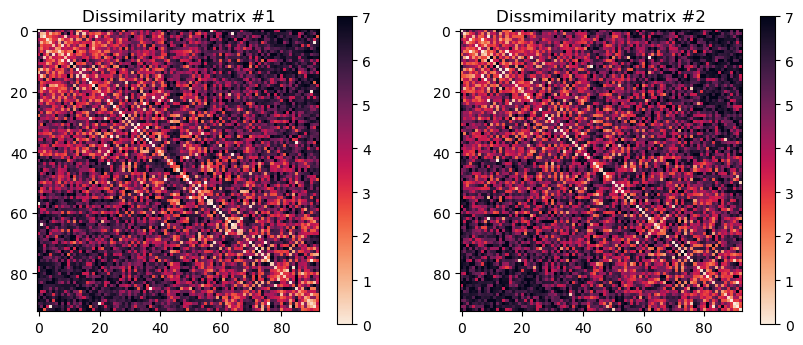

In [2]:
data_path = '../data/color/num_groups_5_seed_0_fill_val_3.5.pickle'
with open(data_path, "rb") as f:
    data = pkl.load(f)
sim_mat_list = data["group_ave_mat"]

C1 = sim_mat_list[0]
C2 = sim_mat_list[1]

# show dissimilarity matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im1 = axes[0].imshow(C1, cmap='rocket_r')
cbar1 = fig.colorbar(im1, ax=axes[0], shrink=0.8)
im2 = axes[1].imshow(C2, cmap='rocket_r')
cbar2 = fig.colorbar(im2, ax=axes[1], shrink=0.8)

axes[0].set_title('Dissimilarity matrix #1')
axes[1].set_title('Dissmimilarity matrix #2')
plt.show()

## Step:2 set the parameter used for computing and saving the results

In [3]:
# Set the range of the epsilon
# set the minimum value and maximum value for "tpe" sampler
# for "grid" or "random" sampler, you can also set the step size    
eps_list = [1e-2, 1e-1]  # [1e-2, 1e-1, 1e-3]
device = "cpu"
to_types = "numpy"

# whether epsilon is sampled at log scale or not
eps_log = True

# Set the params for the trial of optimize and max iteration for gw alignment computation
# set the number of trials, i.e., the number of epsilon values tested in optimization: default : 20
num_trial = 20

# the maximum number of iteration for GW optimization: default: 1000
max_iter = 200

# choose sampler
sampler_name = 'tpe'

# choose pruner
pruner_name = 'hyperband'
pruner_params = {'n_startup_trials': 1, 'n_warmup_steps': 2, 'min_resource': 2, 'reduction_factor' : 3}

# initialization of transportation plan
# 'uniform': uniform matrix, 'diag': diagonal matrix', random': random matrix, 'permutation': permutation matrix
init_mat_plan = 'random'

# the number of random initial matrices for 'random' or 'permutation' options：default: 100
n_iter = 1

## Set the parameters for GW alignment computation 
# please choose the method of sinkhorn implemented by POT (URL : https://pythonot.github.io/gen_modules/ot.bregman.html#id87). For using GPU, "sinkhorn_log" is recommended.
sinkhorn_method = 'sinkhorn'

# user can define the dtypes both for numpy and torch, "float(=float32)" or "double(=float64)". For using GPU with "sinkhorn", double is storongly recommended.
data_type = 'double'

### Set the filename and folder name for saving optuna results  
filename is also treated as optuna study_name

In [4]:
filename = 'test'
save_path = '../results/tutorial_minimal/' + filename + '/' + sampler_name

### Set the database URL to store the optimization results.  

The URL notation should follow the SQLAlchemy documentation:   
https://docs.sqlalchemy.org/en/20/core/engines.html  

To use remote databases, you need to start the database server beforehand. For detailed instruction, please refer to the Optuna official tutorial:  
https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/004_distributed.html  

When using SQLite, the database file is automatically created, so you only need to set the URL.

In [5]:
# Specify the RDB to use for distributed calculations
db_params={"drivername": "sqlite"} # SQLite
# db_params={"drivername": "mysql+pymysql", "username": "root", "password": "****", "host": "localhost"} # MySQL

if db_params["drivername"] == "sqlite":
    storage = "sqlite:///" + save_path +  '/' + filename + '.db'
else:
    # Generate the URL for the database. Syntax differs for SQLite and others.
    storage = URL.create(database=filename, **db_params).render_as_string(hide_password=False)

## Step:3 Perform GW Alignment

In [6]:
# generate instance solves gw_alignment　
test_gw = GW_Alignment(
    C1, 
    C2, 
    save_path, 
    study_name=filename,
    storage=storage,
    max_iter = max_iter, 
    n_iter = n_iter, 
    to_types = to_types,
    data_type = data_type,
    sinkhorn_method = sinkhorn_method, 
    instance_name=filename,  
)

In [7]:
# generate instance optimize gw_alignment　
opt = load_optimizer(
    save_path=save_path,
    filename=filename,
    storage=storage,
    init_mat_plan=init_mat_plan,
    n_iter = n_iter,
    num_trial = num_trial,
    n_jobs = 1,    
    method = 'optuna',
    sampler_name = sampler_name,
    pruner_name = pruner_name,
    pruner_params = pruner_params,
)

### Compute GW Alignment

In [8]:
### Running the Optimization using `opt.run_study`
# 2. run optimzation
study = opt.run_study(
    test_gw,
    seed=42,
    init_mat_plan=init_mat_plan,
    eps_list=eps_list,
    eps_log=eps_log,
    search_space=None,
)

[I 2024-10-24 14:44:53,042] A new study created in RDB with name: test_random


Study for test_random was not found, creating a new one...


  0%|          | 0/1 [00:00<?, ?it/s]

/home/masaru-sasaki/.pyenv/versions/mambaforge-23.11.0-0/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
[I 2024-10-24 14:45:00,287] Trial 0 finished with value: 2.221891464855481 and parameters: {'eps': 0.023688639503640783}. Best is trial 0 with value: 2.221891464855481.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:45:07,213] Trial 1 finished with value: 1.9339563913661841 and parameters: {'eps': 0.08927180304353628}. Best is trial 1 with value: 1.9339563913661841.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:45:12,507] Trial 2 finished with value: 1.9372211697708301 and parameters: {'eps': 0.05395030966670229}. Best is trial 1 with value: 1.9339563913661841.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:45:19,427] Trial 3 finished with value: 1.913570924427196 and parameters: {'eps': 0.03968793330444373}. Best is trial 3 with value: 1.913570924427196.


  0%|          | 0/1 [00:00<?, ?it/s]

/home/masaru-sasaki/.pyenv/versions/mambaforge-23.11.0-0/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:498: RuntimeWarning: overflow encountered in divide
  v = b / KtransposeU
/home/masaru-sasaki/.pyenv/versions/mambaforge-23.11.0-0/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/masaru-sasaki/.pyenv/versions/mambaforge-23.11.0-0/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:498: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
/home/masaru-sasaki/work_space/GWTune/scripts/../src/gw_alignment.py:649: UserWarning: Solver failed to produce a transport plan (checked by original POT). 
  warnings.warn("Solver failed to produce a transport plan (checked by original POT). ")
[I 2024-10-24 14:45:19,605] Trial 4 pruned. All iteration was failed with parameters: {'eps': 0.014322493718230255, 'initialize': 'random'}


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:45:19,774] Trial 5 pruned. All iteration was failed with parameters: {'eps': 0.01432169828911152, 'initialize': 'random'}


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:45:19,959] Trial 6 pruned. All iteration was failed with parameters: {'eps': 0.011430983876313222, 'initialize': 'random'}


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:45:26,557] Trial 7 finished with value: 1.9400423338105857 and parameters: {'eps': 0.07348118405270448}. Best is trial 3 with value: 1.913570924427196.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:45:33,505] Trial 8 finished with value: 2.1812019721577096 and parameters: {'eps': 0.039913058785616795}. Best is trial 3 with value: 1.913570924427196.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:45:40,506] Trial 9 finished with value: 1.8237990187726152 and parameters: {'eps': 0.051059032093947576}. Best is trial 9 with value: 1.8237990187726152.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:45:47,641] Trial 10 finished with value: 1.9353861378793902 and parameters: {'eps': 0.020480725405025005}. Best is trial 9 with value: 1.8237990187726152.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:45:54,572] Trial 11 finished with value: 2.146568328463266 and parameters: {'eps': 0.03878206917550428}. Best is trial 9 with value: 1.8237990187726152.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:46:01,566] Trial 12 finished with value: 1.881158082412507 and parameters: {'eps': 0.06132929504673982}. Best is trial 9 with value: 1.8237990187726152.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:46:08,476] Trial 13 finished with value: 1.9587852645507025 and parameters: {'eps': 0.059761842457339405}. Best is trial 9 with value: 1.8237990187726152.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:46:14,287] Trial 14 finished with value: 1.9459273862966087 and parameters: {'eps': 0.055316982165875446}. Best is trial 9 with value: 1.8237990187726152.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:46:21,223] Trial 15 finished with value: 2.3674647895273404 and parameters: {'eps': 0.08084716496554308}. Best is trial 9 with value: 1.8237990187726152.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:46:28,208] Trial 16 finished with value: 1.932764804837525 and parameters: {'eps': 0.027371661175680666}. Best is trial 9 with value: 1.8237990187726152.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:46:34,972] Trial 17 finished with value: 1.8146732407972181 and parameters: {'eps': 0.06575126209506993}. Best is trial 17 with value: 1.8146732407972181.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:46:41,912] Trial 18 finished with value: 2.003797595556425 and parameters: {'eps': 0.03246479192694332}. Best is trial 17 with value: 1.8146732407972181.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-24 14:46:46,242] Trial 19 finished with value: 1.845223080181059 and parameters: {'eps': 0.09899728574761585}. Best is trial 17 with value: 1.8146732407972181.


## Step:4 View the result

In [9]:
### View Results
display(study.trials_dataframe().sort_values('params_eps'))

,number,value,datetime_start,datetime_complete,duration,params_eps,user_attrs_best_acc,user_attrs_best_iter,user_attrs_best_seed,user_attrs_elapsed_time,user_attrs_error,user_attrs_iteration,user_attrs_source_size,user_attrs_target_size,state
6,6,NaN,2024-10-24 14:45:19.779732,2024-10-24 14:45:19.933230,0 days 00:00:00.153498,0.011431,NaN,NaN,NaN,NaN,NaN,NaN,93,93,PRUNED
5,5,NaN,2024-10-24 14:45:19.610734,2024-10-24 14:45:19.759897,0 days 00:00:00.149163,0.014322,NaN,NaN,NaN,NaN,NaN,NaN,93,93,PRUNED
4,4,NaN,2024-10-24 14:45:19.434682,2024-10-24 14:45:19.577563,0 days 00:00:00.142881,0.014322,NaN,NaN,NaN,NaN,NaN,NaN,93,93,PRUNED
10,10,1.935386,2024-10-24 14:45:40.513713,2024-10-24 14:45:47.622198,0 days 00:00:07.108485,0.020481,0.118280,0.0,92235.0,6.759753,3.212846e-02,200.0,93,93,COMPLETE
0,0,2.221891,2024-10-24 14:44:53.198785,2024-10-24 14:45:00.264466,0 days 00:00:07.065681,0.023689,0.021505,0.0,45609.0,6.675712,2.190908e-02,200.0,93,93,COMPLETE
16,16,1.932765,2024-10-24 14:46:21.230105,2024-10-24 14:46:28.189360,0 days 00:00:06.959255,0.027372,0.096774,0.0,58999.0,6.601146,7.034172e-02,200.0,93,93,COMPLETE
18,18,2.003798,2024-10-24 14:46:34.979006,2024-10-24 14:46:41.895644,0 days 00:00:06.916638,0.032465,0.053763,0.0,88251.0,6.582134,8.306893e-02,200.0,93,93,COMPLETE
11,11,2.146568,2024-10-24 14:45:47.648975,2024-10-24 14:45:54.553343,0 days 00:00:06.904368,0.038782,0.096774,0.0,442.0,6.559035,5.275466e-02,200.0,93,93,COMPLETE
3,3,1.913571,2024-10-24 14:45:12.512968,2024-10-24 14:45:19.407774,0 days 00:00:06.894806,0.039688,0.086022,0.0,89535.0,6.571586,3.007573e-02,200.0,93,93,COMPLETE
8,8,2.181202,2024-10-24 14:45:26.563385,2024-10-24 14:45:33.488066,0 days 00:00:06.924681,0.039913,0.021505,0.0,43130.0,6.605541,1.025018e-01,200.0,93,93,COMPLETE


FrozenTrial(number=17, state=TrialState.COMPLETE, values=[1.8146732407972181], datetime_start=datetime.datetime(2024, 10, 24, 14, 46, 28, 215606), datetime_complete=datetime.datetime(2024, 10, 24, 14, 46, 34, 955475), params={'eps': 0.06575126209506993}, user_attrs={'best_acc': 0.23655913978494625, 'best_iter': 0, 'best_seed': 26424, 'elapsed_time': 6.449263334274292, 'error': 0.06153943150411521, 'iteration': 200, 'source_size': 93, 'target_size': 93}, system_attrs={}, intermediate_values={0: 1.8146732407972181}, distributions={'eps': FloatDistribution(high=0.1, log=True, low=0.01, step=None)}, trial_id=18, value=None)


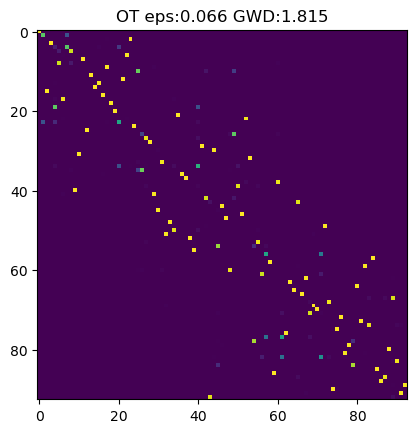

In [10]:
### Extracting the Best Trial from the Study
df_trial = study.trials_dataframe()
best_trial = study.best_trial
print(best_trial)

# extracting optimized epsilon, GWD from best_trial
eps_opt = best_trial.params['eps']
GWD_opt = best_trial.values[0]

# load the opitimized transportation plan from the saved file
if to_types == 'numpy':
    OT = np.load(save_path+f'/gw_{best_trial.number}.npy')
elif to_types == 'torch':
    OT = torch.load(save_path+f'/gw_{best_trial.number}.pt')
    OT = OT.to('cpu').numpy()

# plot the optimal transportation plan
plt.imshow(OT)
plt.title(f'OT eps:{eps_opt:.3f} GWD:{GWD_opt:.3f}')
plt.show()


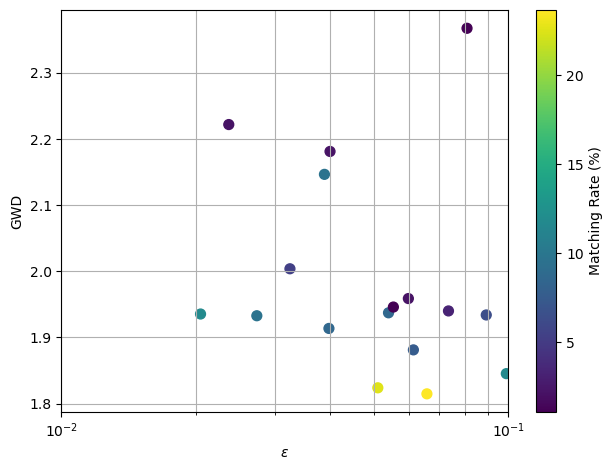

In [11]:
# figure plotting epsilon as x-axis and GWD as y-axis
df_trial = study.trials_dataframe()

plt.scatter(df_trial['params_eps'], df_trial['value'], s = 50, c=df_trial['user_attrs_best_acc'] * 100, cmap='viridis')
plt.xlabel('$\epsilon$')
plt.ylabel('GWD')
plt.colorbar(label='Matching Rate (%)')
plt.grid(True, which="both")
if eps_log:
    plt.xscale('log')

plt.gca().xaxis.set_minor_formatter(ticker.NullFormatter())
plt.xlim(eps_list[0], eps_list[-1])
plt.tight_layout()
plt.show()

accuracy=23.655913978494624%


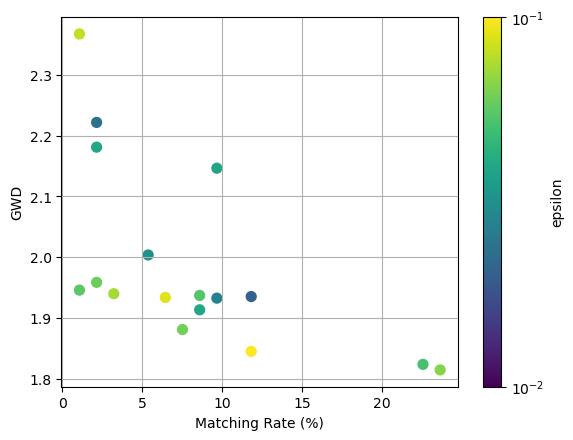

In [12]:
# evaluate accuracy of unsupervised alignment
max_indices = np.argmax(OT, axis=1)
accuracy = np.mean(max_indices == np.arange(OT.shape[0])) * 100
print(f'accuracy={accuracy}%')


#　figure plotting GWD as x-axis and accuracy as y-axis
plt.scatter(df_trial['user_attrs_best_acc'] * 100, df_trial['value'], s = 50, c= df_trial['params_eps'], norm=colors.LogNorm(vmin=eps_list[0], vmax=eps_list[-1]), cmap='viridis')
plt.xlabel('Matching Rate (%)')
plt.ylabel('GWD')
plt.grid(True, which="both")
cbar = plt.colorbar(label='epsilon')
cbar.ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
cbar.ax.yaxis.set_minor_locator(ticker.NullLocator())  # マイナー目盛を無効にします
plt.show()